

# Versions
* V1-V3 efficientnetb4 + unet
* v4 efficientnetb0 + linknet + dce_jacobian loss
* v5 efficientnetb0 + unet + bce_jacobian 
* v6-v8 add guassian data augmentation
* v14 efficientnetb0 + unet 256 tiles
* v15 efficientnetb0 + linknet
* v9 fix shuffbug
* v10 - v49 
* try to find best learning rate for batchsize 1024 is about 1e-3 to 5e-4 ( version 43 )
* best backbone is efficientnet b2 due to image resolution 
* gpu with batchsize 32 run over 9 hours limit in version 48
* v50 read paper and try more loss function
* v54 add extennal data https://www.kaggle.com/baesiann/glomeruli-hubmap-external-1024x1024
* v60 tuning params for optimizer adam look forward
* v64 ~tpu tensorboard for analysis~ only find tpu profiler for gcp

# Refferences:
1. https://www.kaggle.com/wrrosa/hubmap-tf-with-tpu-efficientunet-512x512-tfrecs (how to create training and inference tfrecords)
2. https://www.kaggle.com/wrrosa/hubmap-tf-with-tpu-efficientunet-512x512-train (training pipeline)
3. https://www.kaggle.com/wrrosa/hubmap-tf-with-tpu-efficientunet-512x512-subm (inference with submission)
4. https://www.kaggle.com/vgarshin/kidney-unet-model-keras-inference?scriptVersionId=58536838 and https://github.com/vgarshin/kaggle_kidney/blob/master/kidney_train.ipynb


# tpu

- [Issue]tpu doesn't support numpy_function 
1. issue: https://github.com/tensorflow/tensorflow/issues/38762

- tpu traning guide
1. https://www.tensorflow.org/guide/data_performance
2. https://www.tensorflow.org/guide/distributed_training


# todo 
1. change tf.image to tf sequence layer https://www.tensorflow.org/tutorials/images/data_augmentation#resizing_and_rescaling
2. 语言特性, tf 特性 和 np 的差异 
3. tf 的特性 流的概念 session 的概念 维度对齐
4. tpu 的特性 tpu的效率
5. 尝试多种loss https://github.com/JunMa11/SegLoss

# Init - parameters, packages, gcs_paths, tpu

In [1]:
# tpu v3-8 https://www.kaggle.com/docs/tpu#tpu2
P = {}
P['EPOCHS'] = 120
# 不同base 的efficeinet 似乎只有模型规模的指数不同! 
# 不是的！！！！！ 不同 baseline 对应了 不同分辨率 https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# 暂时换成b0 调试起来更快
P['BACKBONE'] = 'efficientnetb0' 
#P['BACKBONE'] = 'efficientnetb2' 
P['NFOLDS'] = 5
P['SEED'] = 7788
P['VERBOSE'] = 0
P['DISPLAY_PLOT'] = True 
P['BATCH_COE'] = 8 # BATCH_SIZE = P['BATCH_COE'] * strategy.num_replicas_in_sync
#P['BATCH_COE'] = 32 # for gpu

P['TILING'] = [1024,256] # 1024,512 1024,256 1024,128 1536,512 768,384
P['DIM'] = P['TILING'][1] 
P['DIM_FROM'] = P['TILING'][0]

#P['LR'] = 5e-4
P['LR'] = 5e-4 # for tpu
P['OVERLAPP'] = True
P['STEPS_COE'] = 1

P['patience'] = 20
# 不用外部数据 加速调试
P['extenal'] = False

import yaml
with open(r'params.yaml', 'w') as file:
    yaml.dump(P, file)

In [2]:
#print(P)
#!ls
#!cat params.yaml

In [3]:
! pip install segmentation_models -q
%matplotlib inline

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import glob

from segmentation_models.losses import bce_jaccard_loss
import segmentation_models as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

from kaggle_datasets import KaggleDatasets

AUTO = tf.data.experimental.AUTOTUNE

import tensorflow_addons as tfa

#import albumentations as albu
#from functools import partial

Segmentation Models: using `tf.keras` framework.


In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

BATCH_SIZE = P['BATCH_COE'] * strategy.num_replicas_in_sync

print("Number of accelerators: ", strategy.num_replicas_in_sync)
print("BATCH_SIZE: ", str(BATCH_SIZE))

Number of accelerators:  8
BATCH_SIZE:  64


In [5]:
#strategy

## GCS_PATHS

In [6]:
#import tensorflow_datasets as tfds
GCS_PATH = KaggleDatasets().get_gcs_path('hubmaptfwithtpuefficientunet256tfrecord')
#GCS_PATH = '../input/hubmap-tf-with-tpu-efficientunet-256-tfrecord'
ALL_TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
#ALL_TRAINING_FILENAMES

In [7]:
# 使用shift过1024的 train2数据 这里如果overlap为true会在训练阶段把train2加进去一起训练
if P['OVERLAPP']:
    OVERLAPP = tf.io.gfile.glob(GCS_PATH + '/train2/*.tfrec')
    ALL_TRAINING_FILENAMES += OVERLAPP
    
if P['extenal']:
    extenal = tf.io.gfile.glob(GCS_PATH + '/extenal/*.tfrec')
    ALL_TRAINING_FILENAMES += extenal

In [8]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
print('NUM_TRAINING_IMAGES:' )
#if P['OVERLAPP']:
#    print(count_data_items(ALL_TRAINING_FILENAMES2)+count_data_items(ALL_TRAINING_FILENAMES)+count_data_items(ALL_TRAINING_FILENAMES3))
#else:
print(count_data_items(ALL_TRAINING_FILENAMES))

NUM_TRAINING_IMAGES:
19159


In [9]:
import json
from datetime import datetime

In [10]:
#print("if without overlapp", count_data_items(ALL_TRAINING_FILENAMES))
#print("train2", count_data_items(ALL_TRAINING_FILENAMES2))

# Datasets pipeline

In [11]:
#_r = tf.random.stateless_uniform(())
"""
# 测试一下图片自增对多图片
x = [[[1.0, 2.0, 3.0],
      [4.0, 5.0, 6.0]],
     [[7.0, 8.0, 9.0],
      [10.0, 11.0, 12.0]]]
_seed = (1, 2)
_a = tf.image.stateless_random_saturation([x, x], 0.7, 1.3
                                         #, seed
                                         )
"""

#print(_r)
#plt.imshow(a)
#plt.imshow(b)

#g1 = tf.random.Generator.from_seed(1)
#print(g1.normal(shape=[]))
#g2 = tf.random.get_global_generator()
#print(g2.normal(shape=[]))

#seed = g2.make_seeds(2)[0]
#print(seed)
#color_random = tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int64)
#color_random % 3 == 1

'\n# 测试一下图片自增对多图片\nx = [[[1.0, 2.0, 3.0],\n      [4.0, 5.0, 6.0]],\n     [[7.0, 8.0, 9.0],\n      [10.0, 11.0, 12.0]]]\n_seed = (1, 2)\n_a = tf.image.stateless_random_saturation([x, x], 0.7, 1.3\n                                         #, seed\n                                         )\n'

In [12]:
DIM = P['DIM']
#cutDIM = 128

"""
# 哎 弄了两天 albu 在tpu 下彻底不兼容 如果强行开session转tensor.ops到np会影响性能 这个目前还是没辙
# 数据自增
# https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu
transforms = albu.Compose([
    albu.OneOf([
        albu.RandomBrightness(limit=.2, p=1), 
        albu.RandomContrast(limit=.2, p=1), 
        albu.RandomGamma(p=1)
    ], p=.5),
    albu.OneOf([
        albu.Blur(blur_limit=3, p=1),
        albu.MedianBlur(blur_limit=3, p=1)
    ], p=.25),
    albu.OneOf([
        albu.GaussNoise(0.002, p=.5),
        albu.IAAAffine(p=.5),
    ], p=.25),
    albu.RandomRotate90(p=.5),
    albu.HorizontalFlip(p=.5),
    albu.VerticalFlip(p=.5),
    albu.Cutout(num_holes=10, 
                max_h_size=int(.1 * DIM), max_w_size=int(.1 * DIM), 
                p=.25),
    albu.ShiftScaleRotate(p=.25)
])


def aug_fn(image, img_size, mask):
    data = {"image":image, "mask": mask}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_mask = aug_data["mask"]
    aug_mask = tf.cast(aug_mask, tf.float32)
    aug_mask = tf.image.resize(aug_mask, size=[img_size, img_size])    
    return aug_img, aug_mask
    #return image, mask
"""

#https://www.tensorflow.org/tutorials/images/data_augmentation
def _parse_image_function(example_proto, seed, augment = True):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape( tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'),(DIM,DIM,1))
        
    if augment:
        # 这里代码要改一下 和取 tfrecord分开
        # https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
        
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)    
        # shiftscalerotate 0.25
        if tf.random.uniform(()) > 0.4:	        
            image = tf.image.flip_up_down(image)	        #if tf.random.uniform(()) > 0.75:
            mask = tf.image.flip_up_down(mask)
            
        #image = tf.image.stateless_random_flip_left_right(image, seed) 
        #mask = tf.image.stateless_random_flip_left_right(mask, seed) 

        #image = tf.image.stateless_random_flip_up_down(image, seed)
        #mask = tf.image.stateless_random_flip_up_down(mask, seed)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)      
        # shiftscalerotate 0.25
        
        #if tf.random.uniform(()) > 0.75:
        #    image = tf.image.stateless_random_crop(image, size=[cutDIM, cutDIM, 3], seed=seed)
        #    mask = tf.image.stateless_random_crop(mask, size=[cutDIM, cutDIM, 1], seed=seed)
        
        #  随机调整色调
        if tf.random.uniform(()) > 0.75:
            image = tf.image.stateless_random_hue(image, 0.2, seed=seed)    
        
        #  图片质量 这个好像会造成反向优化
        #if tf.random.uniform(()) > 0.7:
        #    image = tf.image.stateless_random_jpeg_quality(image, 75, 95, seed)
            
        if tf.random.uniform(()) > 0.75:
            image = tf.image.stateless_random_saturation(image, 0.7, 1.3, seed=seed)
            
        if tf.random.uniform(()) > 0.75:
            image = tf.image.stateless_random_contrast(image, lower=0.8, upper=1.2, seed=seed)
        
        if tf.random.uniform(()) > 0.75:
            image = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
        
        """
            #  颜色
            color_random = tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int64)
            color_random_resd = color_random % 3;
            if color_random > 5:
                # 三选一
                if color_random_resd == 2:
                    image = tf.image.stateless_random_saturation(image, 0.7, 1.3, seed=seed)    
                elif color_random_resd == 1:
                    image = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
                else: 
                    # color_random_resd == 0:
                    image = tf.image.stateless_random_contrast(
                      image, lower=0.8, upper=1.2, seed=seed)
                image = tf.clip_by_value(image, 0, 1)
        """
        

        # Blur MedianBlur 二选一 
        
        
        #noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
        #image = image + noise
        
        # albu.GaussNoise(0.002, p=.5),albu.IAAAffine(p=.5), 二选一 0.25
        #image = tf.image.resize(image, [DIM, DIM])
        #mask = tf.image.resize(mask, [DIM, DIM])
    return tf.cast(image, tf.float32), tf.cast(mask, tf.float32)
    """
    # 自增工具 https://albumentations.ai/docs/examples/example_multi_target/
    # map numpy_function 等的说明 https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    aug_image, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, DIM, mask], Tout=[tf.float32, tf.float32])
    # 需要恢复shape https://albumentations.ai/docs/examples/tensorflow-example/#restoring-dataset-shapes
    aug_image.set_shape((DIM,DIM, 3))
    aug_mask.set_shape((DIM,DIM, 1))
    return aug_image, aug_mask
    """

def load_dataset(filenames, ordered=False, augment = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    
    counter = tf.data.experimental.Counter()
    dataset = tf.data.Dataset.zip((dataset, (counter, counter)))
    
    dataset = dataset.map(lambda ex, i: _parse_image_function(ex, i, augment = augment), num_parallel_calls=AUTO)
    #dataset = dataset.map(partial(_parse_image_function, augment = augment), num_parallel_calls=AUTO)
    # 这一行计数会极大的影响性能
    #dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1        
    #print("dataset_length", dataset_length)            
    return dataset
# 之前这里值都一样 现在改成不一样的
def get_training_dataset(index= P['SEED']):
    print("trainning data load")
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(128, seed = index)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=True):
    print("validate data load")
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered, augment = False)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [13]:
#dataset = load_dataset("gs://kds-d633b6ed58b88a8006c19265c98f17c827c34cb7d20242fa7111baa9/train/0486052bb-355.tfrec")

In [14]:
"""
#遇到了一个浅拷贝的问题：get_training_dataset > load_dataset 如果重复运行 “似乎会取错 dataset 的并行执行单元的指针“，取之前被重复赋值之前的指针，而那个指针指向的”并行计算单元“已经被销毁了，就会导致报错“cannot connect alladress”错误

DIM = P['DIM']

transforms = albu.Compose([
    albu.OneOf([
        albu.RandomBrightness(limit=.2, p=1), 
        albu.RandomContrast(limit=.2, p=1), 
        albu.RandomGamma(p=1)
    ], p=.5),
    albu.OneOf([
        albu.Blur(blur_limit=3, p=1),
        albu.MedianBlur(blur_limit=3, p=1)
    ], p=.25),
    albu.OneOf([
        albu.GaussNoise(0.002, p=.5),
        albu.IAAAffine(p=.5),
    ], p=.25),
    albu.RandomRotate90(p=.5),
    albu.HorizontalFlip(p=.5),
    albu.VerticalFlip(p=.5),
    albu.Cutout(num_holes=10, 
                max_h_size=int(.1 * DIM), max_w_size=int(.1 * DIM), 
                p=.25),
    albu.ShiftScaleRotate(p=.25)
])

def aug_fn(image, img_size, mask):
    data = {"image":image, "mask": mask}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    #aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_mask = aug_data["mask"]
    #aug_mask = tf.cast(aug_mask, tf.float32)
    #aug_mask = tf.image.resize(aug_mask, size=[img_size, img_size])
    return aug_img, aug_mask
    #return image, mask

filenames = "gs://kds-d633b6ed58b88a8006c19265c98f17c827c34cb7d20242fa7111baa9/train/0486052bb-355.tfrec"

testArr = []
def _parse_image(example_proto):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape( tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'),(DIM,DIM,1))
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    testArr.append(image)
    testArr.append(mask)
    #aug_image, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, size, mask], Tout=[tf.float32, tf.float32])
    aug_image, aug_mask = aug_fn(image, DIM, mask)
    
    aug_image.set_shape((DIM,DIM, 3))
    aug_mask.set_shape((DIM,DIM, 1))
    return aug_image, aug_mask 
    #return image, mask 
    

dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)

#dataset = dataset.map(partial(_parse_image), num_parallel_calls=AUTO)
dataset_alb = dataset.map(partial(_parse_image), num_parallel_calls=AUTO)
"""
#print(testArr)

'\n#遇到了一个浅拷贝的问题：get_training_dataset > load_dataset 如果重复运行 “似乎会取错 dataset 的并行执行单元的指针“，取之前被重复赋值之前的指针，而那个指针指向的”并行计算单元“已经被销毁了，就会导致报错“cannot connect alladress”错误\n\nDIM = P[\'DIM\']\n\ntransforms = albu.Compose([\n    albu.OneOf([\n        albu.RandomBrightness(limit=.2, p=1), \n        albu.RandomContrast(limit=.2, p=1), \n        albu.RandomGamma(p=1)\n    ], p=.5),\n    albu.OneOf([\n        albu.Blur(blur_limit=3, p=1),\n        albu.MedianBlur(blur_limit=3, p=1)\n    ], p=.25),\n    albu.OneOf([\n        albu.GaussNoise(0.002, p=.5),\n        albu.IAAAffine(p=.5),\n    ], p=.25),\n    albu.RandomRotate90(p=.5),\n    albu.HorizontalFlip(p=.5),\n    albu.VerticalFlip(p=.5),\n    albu.Cutout(num_holes=10, \n                max_h_size=int(.1 * DIM), max_w_size=int(.1 * DIM), \n                p=.25),\n    albu.ShiftScaleRotate(p=.25)\n])\n\ndef aug_fn(image, img_size, mask):\n    data = {"image":image, "mask": mask}\n    aug_data = transforms(**data)\n    aug_img = aug_data["image"]\n    

In [15]:
#import PIL
#import PIL.Image
#type(testArr[0])

#arr = np.ndarray(testArr[0])
#arr_ = np.squeeze(arr)

#plt.imshow(testArr[0])
#plt.show()
#PIL.Image.open(str(testArr[0]))

In [16]:
#type(element)
#get_training_dataset()
#get_validation_dataset()

In [17]:
"""
plt.imshow(element[0])
plt.show()
"""

'\nplt.imshow(element[0])\nplt.show()\n'

In [18]:
#get_validation_dataset()

# Model

In [19]:
# https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
"""
def dice_coe(output, target, axis = None, smooth=1e-10):
    output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
    target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice
"""

def dice_coe(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu
def tversky(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def dice_loss(y_true, y_pred, smooth=1):
    return (1 - dice_coe(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return PARAMS['bce_weight'] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS['bce_weight']) * dice_loss(y_true, y_pred)

get_custom_objects().update({"focal_tversky": focal_tversky_loss})

# Model fit

###################################
############ FOLD  1  #############
###################################
Image Size: 256, Batch Size: 64
16809984/16804768 [==============================] - 0s 0us/step
Training Model Fold 1...
trainning data load
validate data load
validate data load
54/54 [==============================] - 3s 36ms/step - loss: 0.0098 - dice_coe: 0.7640


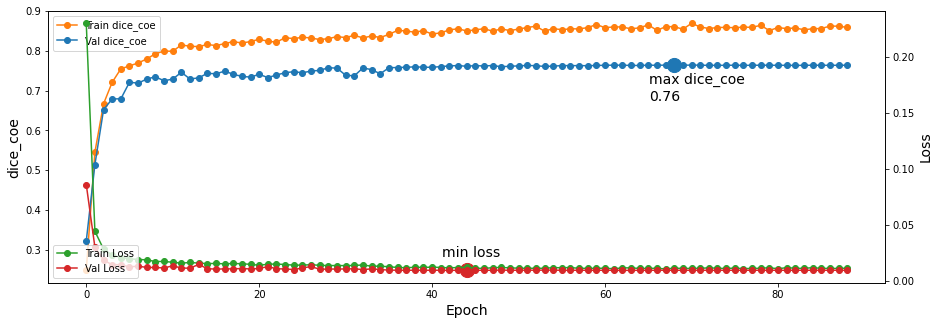

###################################
############ FOLD  2  #############
###################################
Image Size: 256, Batch Size: 64
Training Model Fold 2...
trainning data load
validate data load
validate data load
55/55 [==============================] - 3s 38ms/step - loss: 0.0122 - dice_coe: 0.8885


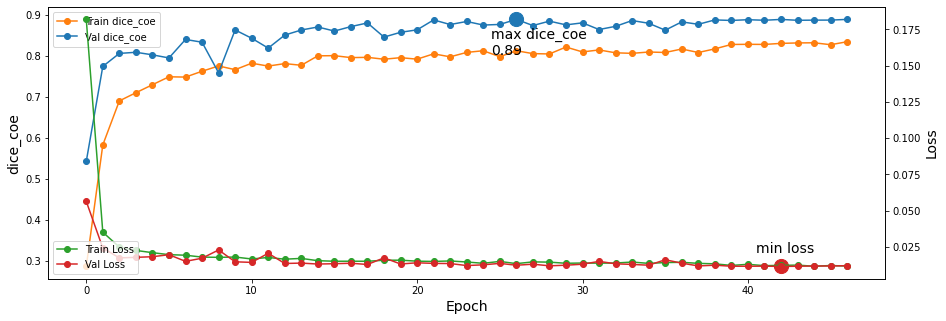

###################################
############ FOLD  3  #############
###################################
Image Size: 256, Batch Size: 64
Training Model Fold 3...
trainning data load
validate data load
validate data load
65/65 [==============================] - 3s 37ms/step - loss: 0.0093 - dice_coe: 0.8022


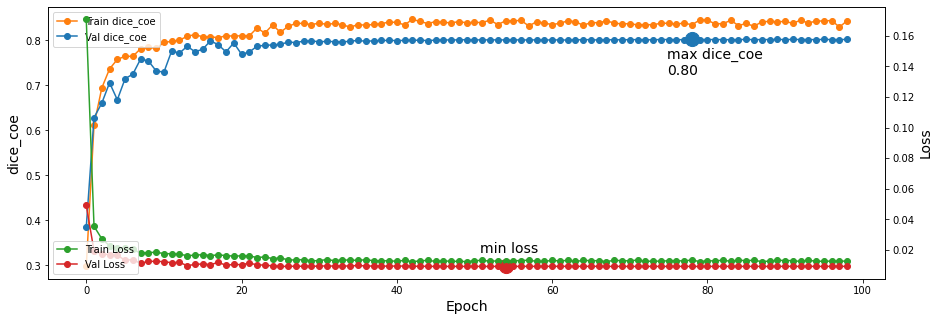

###################################
############ FOLD  4  #############
###################################
Image Size: 256, Batch Size: 64
Training Model Fold 4...
trainning data load
validate data load
validate data load
59/59 [==============================] - 3s 38ms/step - loss: 0.0082 - dice_coe: 0.7520


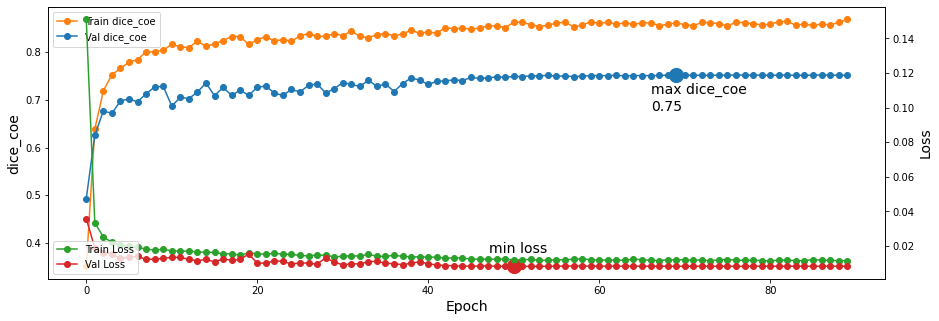

###################################
############ FOLD  5  #############
###################################
Image Size: 256, Batch Size: 64
Training Model Fold 5...
trainning data load
validate data load
validate data load
64/64 [==============================] - 3s 37ms/step - loss: 0.0134 - dice_coe: 0.8834


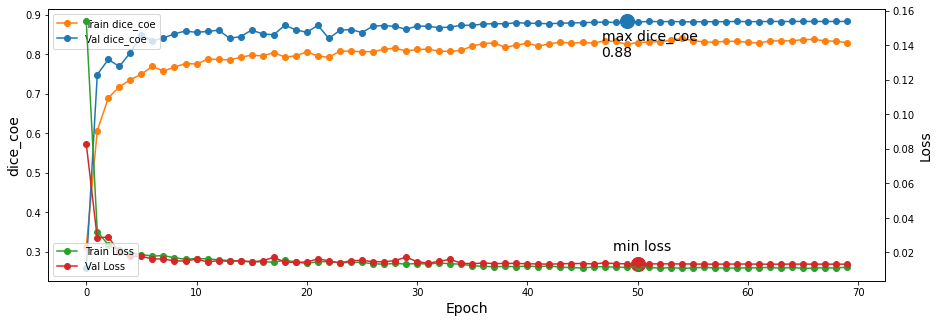

CPU times: user 23min 17s, sys: 3min 38s, total: 26min 55s
Wall time: 2h 36min 49s


In [20]:
%%time

M = {}
metrics = ['loss','dice_coe'
           #,'accuracy'
          ]
for fm in metrics:
    M['val_'+fm] = []

fold = KFold(n_splits=P['NFOLDS'], shuffle=True, random_state=P['SEED'])
for fold,(tr_idx, val_idx) in enumerate(fold.split(ALL_TRAINING_FILENAMES)):
    print('#'*35); print('############ FOLD ',fold+1,' #############'); print('#'*35);
    print(f'Image Size: {DIM}, Batch Size: {BATCH_SIZE}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = [ALL_TRAINING_FILENAMES[fi] for fi in tr_idx]
    
    #这段似乎不太对
    """    
    if P['OVERLAPP']:
        TRAINING_FILENAMES += [ALL_TRAINING_FILENAMES2[fi] for fi in tr_idx]
    """

    VALIDATION_FILENAMES = [ALL_TRAINING_FILENAMES[fi] for fi in val_idx]
    STEPS_PER_EPOCH = P['STEPS_COE'] * count_data_items(TRAINING_FILENAMES) // BATCH_SIZE

    # BUILD MODEL
    K.clear_session()
    with strategy.scope():   
        model = sm.Unet(P['BACKBONE'], encoder_weights='imagenet')
        #model = sm.Linknet(P['BACKBONE'], encoder_weights='imagenet')
        #https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch 目前最好的lr 为 1e-3 到  5e-4 附近
        """
        model.compile(optimizer=tfa.optimizers.Lookahead(
            tf.keras.optimizers.Adam(learning_rate=P['LR']),
            sync_period=max(6, int(P['patience'] / 4))
          ),
        
        """

        model.compile(optimizer = tf.keras.optimizers.Adam(lr = P['LR']),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      
                      #loss='focal_tversky',
                      
                      #loss = bce_jaccard_loss,
                      metrics=[dice_coe
                              # ,'accuracy'
                              ])
    """
      optimizer=tfa.optimizers.Lookahead(
            tf.keras.optimizers.Adam(learning_rate=P['LR']),
            sync_period=max(6, int(P['patience'] / 4))
      ),
    """

    # CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model-fold-%i.h5'%fold,
                                 verbose=P['VERBOSE'],monitor='val_dice_coe',
                                                    #patience = 10,
                                 mode='max',save_best_only=True)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coe',mode = 'max', patience=P['patience'], restore_best_weights=True)
    reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(P['patience'] / 2), min_lr=P['LR'] / 1e3)

    print(f'Training Model Fold {fold+1}...')

    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
        get_training_dataset(index=fold),
        epochs = P['EPOCHS'],
        steps_per_epoch = STEPS_PER_EPOCH,
        callbacks = [
            #tensorboard_callback, 
            checkpoint, reduce,early_stop],
        validation_data = get_validation_dataset(),
        verbose=P['VERBOSE']
    )   

    #with strategy.scope():
    #    model = tf.keras.models.load_model('/kaggle/working/model-fold-%i.h5'%fold, custom_objects = {"dice_coe": dice_coe})

    # SAVE METRICS
    m = model.evaluate(get_validation_dataset(),return_dict=True)
    for fm in metrics:
        M['val_'+fm].append(m[fm])

    # PLOT TRAINING
    # https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords
    if P['DISPLAY_PLOT']:        
        plt.figure(figsize=(15,5))
        n_e = np.arange(len(history.history['dice_coe']))
        plt.plot(n_e,history.history['dice_coe'],'-o',label='Train dice_coe',color='#ff7f0e')
        plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')
        x = np.argmax( history.history['val_dice_coe'] ); y = np.max( history.history['val_dice_coe'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max dice_coe\n%.2f'%y,size=14)
        plt.ylabel('dice_coe',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(n_e,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(n_e,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.legend(loc=3)
        plt.show()

In [21]:
### WRITE METRICS
M['datetime'] = str(datetime.now())
for fm in metrics:
    M['oof_'+fm] = np.mean(M['val_'+fm])
    print('OOF '+ fm + ' '+ str(M['oof_'+fm]))
with open('metrics.json', 'w') as outfile:
    json.dump(M, outfile)

OOF loss 0.010590329021215438
OOF dice_coe 0.8180125236511231


In [22]:
# this need some special configurature for tpu 
#%tensorboard --logdir logs/fit

In [23]:
#!ls